In [1]:
import matplotlib.pyplot as plt
from matplotlib import image
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
import cv2
import os
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
from Utils import *
from open3d.web_visualizer import draw
from joblib import Parallel, delayed
from VisulizerTools import *
from DDBSCAN import Raster_DBSCAN
import time
plt.rcParams["font.family"] = "Times New Roman"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [16]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\California\2021-12-10-21-0-0.pcap'
end_frame = 18000
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)
Inten_maps = np.array(Inten_maps)

 99%|███████████████████████████████████████████████████████████████████████████▎| 17846/18000 [12:01<00:06, 24.73it/s]


In [6]:
test_points = pd.read_excel(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Data\TestPoint.xlsx')

In [4]:
def calc_d(d):
    temp = 3*10**(-5) * d**2 + 6.3*10**(-4) * d + 3.5*10**(-3)
    return 3*temp 

In [5]:
def get_thred(temp,N = 10,d_thred = 0.1,bck_n = 3):
    temp = temp.copy()
    total_sample = len(temp)
    bck_ds = []
    bck_portions = []
    repeat = 0
    while repeat < N:
        if len(temp) == 0:
            break
        sample = np.random.choice(temp,replace=False)
        d = calc_d(sample)
        ind = np.abs(temp - sample) < d
        portion = ind.sum()/total_sample
        if portion > d_thred:
            bck_portions.append(portion)
            bck_ds.append(sample)
            temp = temp[~ind]
        repeat += 1
        
    bck_ds = np.array(bck_ds)
    bck_portions = np.array(bck_portions)
    arg_ind = np.argsort(bck_portions)[::-1]
    bck_ds_ = bck_ds[arg_ind[:bck_n]]
    
    if len(bck_ds_) <= bck_n:
        bck_ds_ = np.concatenate([bck_ds_,-1 * np.ones(bck_n - len(bck_ds_))])
    return bck_ds_

def gen_bckmap(aggregated_maps, N, d_thred, bck_n):
    thred_map = np.zeros((3,32,1800))
    for i in tqdm(range(thred_map.shape[1])):
        for j in range(thred_map.shape[2]):
            thred_map[:,i,j] = get_thred(aggregated_maps[:,i,j],N = N,d_thred = d_thred,bck_n = bck_n)
    return thred_map

In [17]:
thred_map = gen_bckmap(aggregated_map, N = 10,d_thred = 0.08,bck_n = 3 )

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:56<00:00,  1.75s/it]


In [9]:
np.save(r'D:\LiDAR_Data\MidTown\California\Fri\thred_map_11.npy',thred_map)

In [19]:
Td_map = aggregated_map[12365]
Foreground_map = ~(np.abs(Td_map - thred_map) <= 1.5).any(axis = 0)
pcd = get_pcd_colored(Td_map,Foreground_map)
draw(pcd,height=1000,width=1000)# Labeling_map = self.db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)

WebVisualizer(window_uid='window_10')

0.0
1452


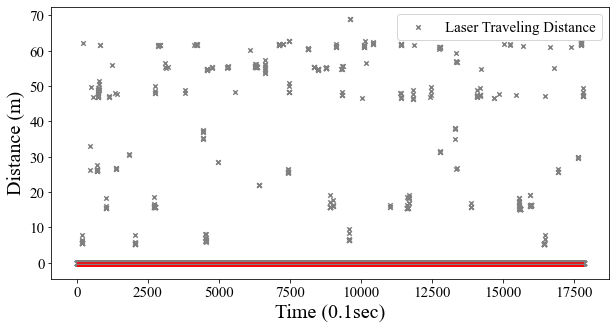

In [100]:
laser_id = 20
azimuth_channel = 1452
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
# plt.ylim(2.5,3)
# plt.xlim(1400,1500)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\MultiModal.tif', dpi = 600)
plt.show()

In [53]:
Td_map = aggregated_map[446]
Colored_map = -1*np.ones_like(Td_map)
Colored_map[3:4,1150:1200] = 0
Colored_map = Colored_map.astype(int)
pcd = get_pcd_colored(Td_map,Colored_map)
draw(pcd,height=1000,width=1000)


WebVisualizer(window_uid='window_45')

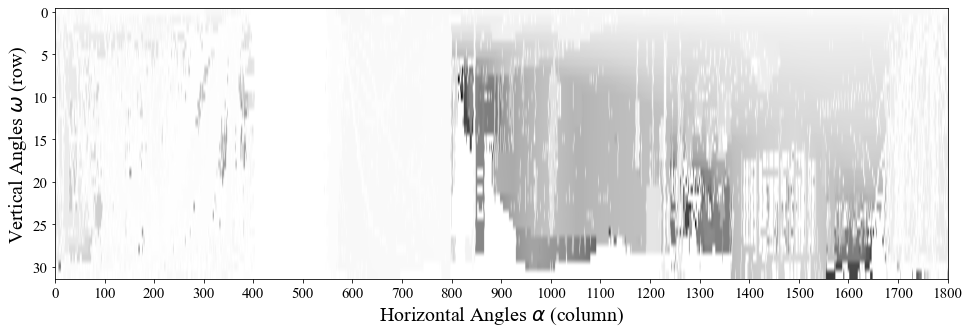

In [12]:
plt.figure(figsize=(16,5))
plt.imshow(aggregated_map[235], aspect='auto',cmap = 'binary')
plt.xlabel(r'Horizontal Angles $\mathit{\alpha}$ (column)',fontsize = 20)
plt.ylabel(r'Vertical Angles $\mathit{\omega} $ (row)',fontsize = 20)
plt.yticks(fontsize = 15)
plt.xticks(np.arange(0,1900,100),fontsize = 15)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\Picture4.tif',dpi = 600)
plt.show()

[22.464]
1463


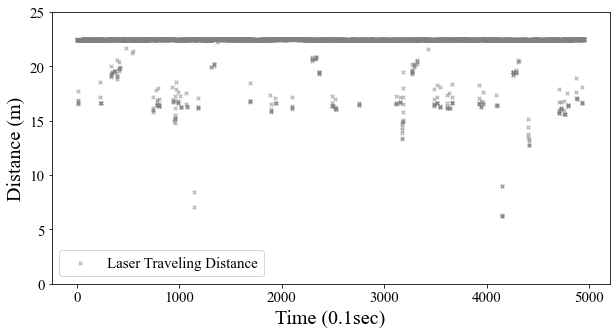

In [18]:
laser_id = theta_raw[28] == theta
azimuth_channel = int(np.around((28661/100)/0.2)) + 30
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
temp = temp[temp != 0]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 12, marker = 'x', label = "Laser Traveling Distance", c = 'gray', alpha = 0.5)
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
plt.ylim(0,25)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\Picture5.tif', dpi = 600)
plt.show()

In [176]:
theta_raw = np.array([[-25,1.4],[-1,-4.2],[-1.667,1.4],[-15.639,-1.4],
                            [-11.31,1.4],[0,-1.4],[-0.667,4.2],[-8.843,-1.4],
                            [-7.254,1.4],[0.333,-4.2],[-0.333,1.4],[-6.148,-1.4],
                            [-5.333,4.2],[1.333,-1.4],[0.667,4.2],[-4,-1.4],
                            [-4.667,1.4],[1.667,-4.2],[1,1.4],[-3.667,-4.2],
                            [-3.333,4.2],[3.333,-1.4],[2.333,1.4],[-2.667,-1.4],
                            [-3,1.4],[7,-1.4],[4.667,1.4],[-2.333,-4.2],
                            [-2,4.2],[15,-1.4],[10.333,1.4],[-1.333,-1.4]
                            ])[:,0]

In [41]:
aggregated_map = np.array(aggregated_map)

44.788000000000004
1354


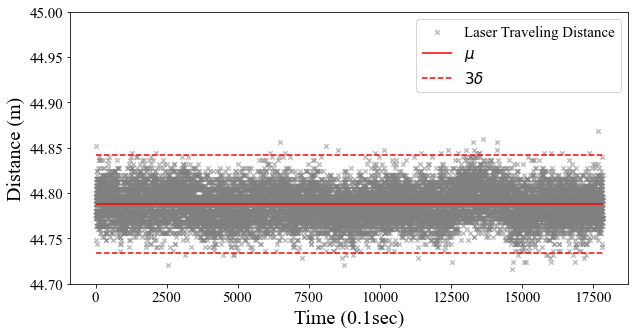

In [76]:
laser_id = 5
azimuth_channel = 1354
print(np.median(aggregated_map[:,laser_id,azimuth_channel]))
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray', alpha = 0.5)
test = temp[(temp >44.7)&(temp < 44.9)]
plt.hlines(test.mean(),0,len(temp),color = 'r',label = '$\mu$')
plt.hlines(test.mean() + 3*test.std(),0,len(temp),color = 'r',label = '$3\delta$',linestyles = 'dashed')
plt.hlines(test.mean() - 3*test.std(),0,len(temp),color = 'r',linestyles = 'dashed')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
plt.ylim(44.7,45)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\DsWidth.tif',dpi = 600)
plt.show()

56.048
1354


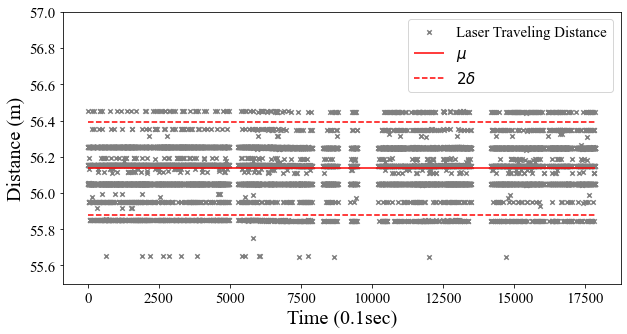

In [46]:
laser_id = 16
azimuth_channel = 1354
print(np.median(aggregated_map[:,laser_id,azimuth_channel]))
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
plt.hlines(test.mean(),0,len(temp),color = 'r',label = '$\mu$')
plt.hlines(test.mean() + 2*test.std(),0,len(temp),color = 'r',label = '$2\delta$',linestyles = 'dashed')
plt.hlines(test.mean() - 2*test.std(),0,len(temp),color = 'r',linestyles = 'dashed')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
plt.ylim(55.5,57)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\contantWidth.tif',dpi = 600)
plt.show()

In [27]:
test = temp[(temp >55.5)&(temp < 56.8)]


In [680]:
test = temp[(temp >192)&(temp < 194)]
med = np.median(test)
np.save(r'D:\LiDAR_Data\AmplitudeTest\Liberty\Snowy/{}.npy'.format(med),test)

In [34]:
Td_map = aggregated_map[482]
Colored_map = -1*np.ones_like(Td_map)
Colored_map[6:8,1750:1799] = 0
Colored_map = Colored_map.astype(int)
pcd = get_pcd_colored(Td_map,Colored_map)
draw(pcd,height=1000,width=1000)


WebVisualizer(window_uid='window_7')

18.624
1226


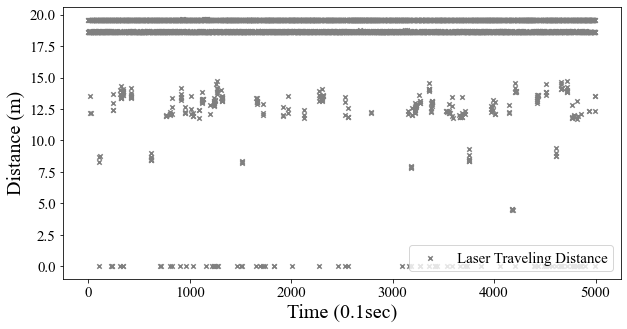

In [66]:
laser_id = 3
azimuth_channel = 1226
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
# for i in range(len(thred)):
#     plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.legend(fontsize = 15,loc = 'lower right')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
# plt.ylim(3,3.25)
# plt.xlim(1400,1500)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\MultiModal2.tif', dpi = 600)
plt.show()

18.624
1226


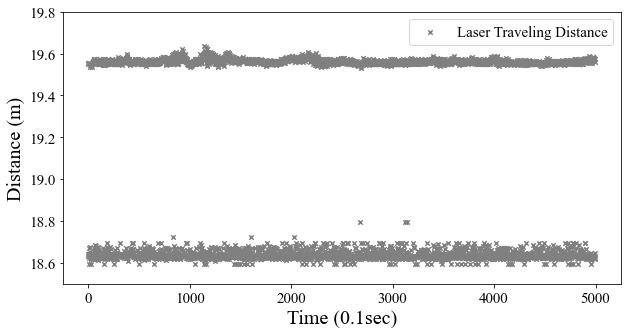

In [74]:
laser_id = 3
azimuth_channel = 1226
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
# for i in range(len(thred)):
#     plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
plt.ylim(18.5,19.8)
# plt.xlim(1400,1500)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\MultiModal3.tif', dpi = 600)
plt.show()

0.0
138


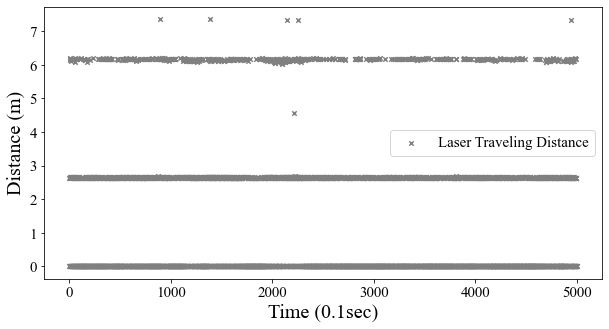

In [45]:
laser_id = 8
azimuth_channel = int((3376/100)/0.2) - 30
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
# for i in range(len(thred)):
#     plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
# plt.ylim(0,65)
# plt.xlim(1400,1500)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\MultiModal.tif', dpi = 600)
plt.show()

29.580000000000002
1345


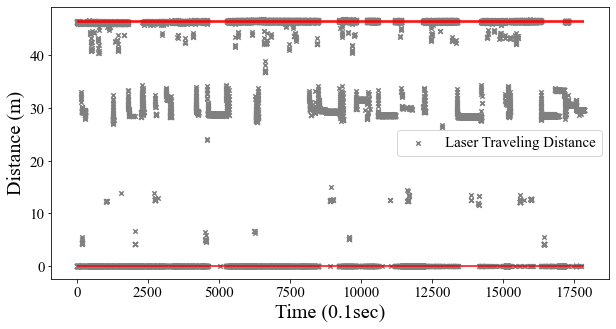

In [29]:
laser_id = 3
azimuth_channel = 1345
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
# plt.ylim(0,65)
# plt.xlim(1400,1500)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\MultiModal.tif', dpi = 600)
plt.show()

[51.9]
138


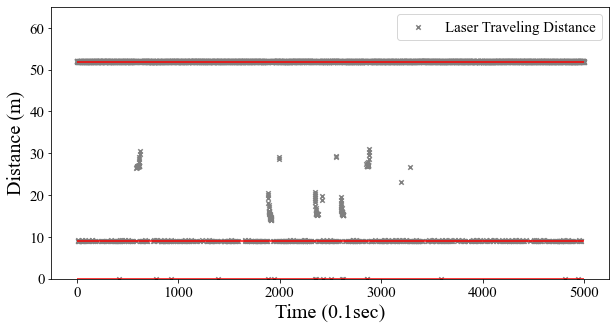

In [9]:
laser_id = theta_raw[5] == theta
azimuth_channel = int((3376/100)/0.2) - 30
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
plt.ylim(0,65)
# plt.xlim(1400,1500)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\MultiModal.tif', dpi = 600)
plt.show()

In [22]:
thred_map = gen_bckmap(aggregated_map, d = 0.5, thred_s = 0.3, N = 20, delta_thred = 0.001, step = 0.1)

In [14]:
np.save(r'D:\Test\bck.npy',thred_map)

In [13]:
Td_map = aggregated_map[482]
Colored_map = Td_map < thred_map
# Colored_map[:,700:900] = 1
pcd = get_pcd_colored(Td_map,Colored_map)
draw(pcd,height=1000,width=1000)


WebVisualizer(window_uid='window_3')

In [ ]:
laser_id = theta_raw[24] == theta
azimuth_channel = int(np.around((27979/100)/0.2)) + 30
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
temp = temp[temp != 0]
plt.figure(figsize=(13,5))
plt.scatter(np.arange(len(temp)),temp,s = 30, marker = 'x', label = "Background", alpha = 0.6)
temp_out = temp[temp < 33.6]
plt.scatter(np.where(temp < 33.6)[0],temp_out,s = 30, marker = 'x', label = "Foreground",c = 'r', alpha = 0.6)
plt.hlines(33.6,0,2000,color = 'g', label = "Identified Background Distance",)
plt.legend(fontsize = 15,loc = 'lower right')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
plt.ylim(33,34)
# plt.xlim(220,250)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\Picture13.tif', dpi = 600)
plt.show()

[33.608]
1429


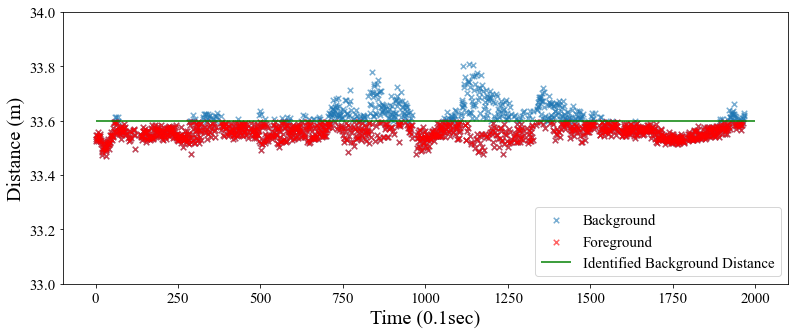

In [74]:
laser_id = theta_raw[24] == theta
azimuth_channel = int(np.around((27979/100)/0.2)) + 30
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
temp = temp[temp != 0]
plt.figure(figsize=(13,5))
plt.scatter(np.arange(len(temp)),temp,s = 30, marker = 'x', label = "Background", alpha = 0.6)
temp_out = temp[temp < 33.6]
plt.scatter(np.where(temp < 33.6)[0],temp_out,s = 30, marker = 'x', label = "Foreground",c = 'r', alpha = 0.6)
plt.hlines(33.6,0,2000,color = 'g', label = "Identified Background Distance",)
plt.legend(fontsize = 15,loc = 'lower right')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
plt.ylim(33,34)
# plt.xlim(220,250)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\Picture13.tif', dpi = 600)
plt.show()

[33.608]
1429


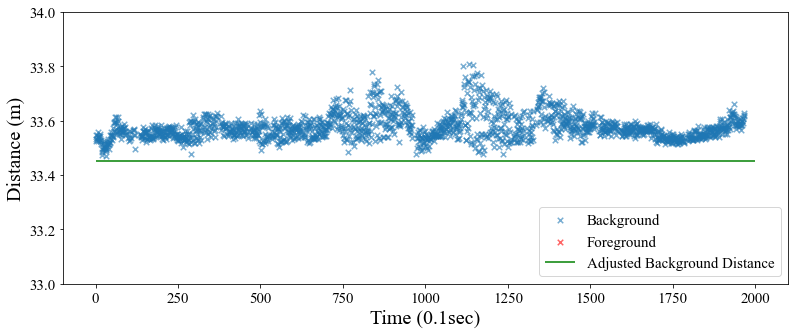

In [77]:
laser_id = theta_raw[24] == theta
azimuth_channel = int(np.around((27979/100)/0.2)) + 30
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
temp = temp[temp != 0]
plt.figure(figsize=(13,5))
plt.scatter(np.arange(len(temp)),temp,s = 30, marker = 'x', label = "Background", alpha = 0.6)
temp_out = temp[temp < 33.4]
plt.scatter(np.where(temp < 33.4)[0],temp_out,s = 30, marker = 'x', label = "Foreground",c = 'r', alpha = 0.6)
plt.hlines(33.45,0,2000,color = 'g', label = "Adjusted Background Distance")
plt.legend(fontsize = 15,loc = 'lower right')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
plt.ylim(33,34)
# plt.xlim(220,250)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\Picture14.tif', dpi = 600)
plt.show()

[33.608]
1429


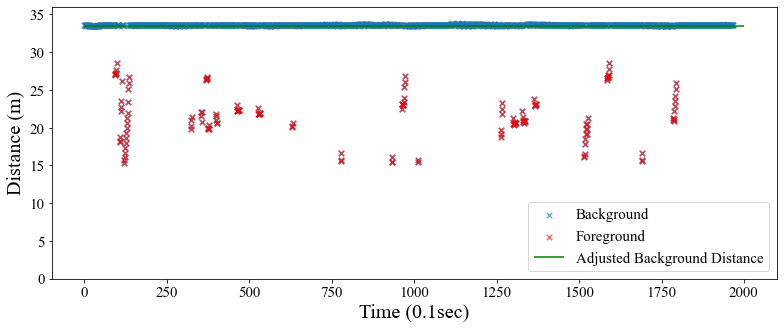

In [83]:
laser_id = theta_raw[24] == theta
azimuth_channel = int(np.around((27979/100)/0.2)) + 30
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
temp = temp[temp != 0]
plt.figure(figsize=(13,5))
plt.scatter(np.arange(len(temp)),temp,s = 30, marker = 'x', label = "Background", alpha = 0.6)
temp_out = temp[temp < 33.4]
plt.scatter(np.where(temp < 33.4)[0],temp_out,s = 30, marker = 'x', label = "Foreground",c = 'r', alpha = 0.6)
plt.hlines(33.45,0,2000,color = 'g', label = "Adjusted Background Distance")
plt.legend(fontsize = 15,loc = 'lower right')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
plt.ylim(0,36)
# plt.xlim(220,250)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\Picture15.tif', dpi = 600)
plt.show()

[33.608]
1429


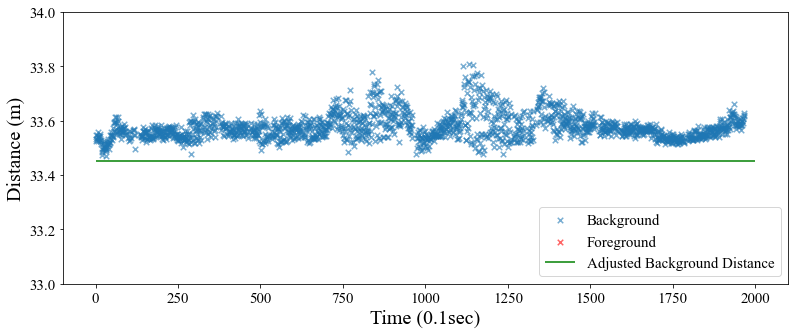

In [84]:
laser_id = theta_raw[24] == theta
azimuth_channel = int(np.around((27979/100)/0.2)) + 30
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
temp = temp[temp != 0]
plt.figure(figsize=(13,5))
plt.scatter(np.arange(len(temp)),temp,s = 30, marker = 'x', label = "Background", alpha = 0.6)
temp_out = temp[temp < 33.4]
plt.scatter(np.where(temp < 33.4)[0],temp_out,s = 30, marker = 'x', label = "Foreground",c = 'r', alpha = 0.6)
plt.hlines(33.45,0,2000,color = 'g', label = "Adjusted Background Distance")
plt.legend(fontsize = 15,loc = 'lower right')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
plt.ylim(33,34)
# plt.xlim(220,250)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\Picture14.tif', dpi = 600)
plt.show()

In [3]:
f_path = r'D:\LiDAR_Data\AmplitudeTest\Total'
path_amp = os.listdir(f_path)
dis_Total  = []
amps = []
for p in path_amp:
    test = np.load(os.path.join(f_path,p))
    dis_Total .append(eval(p[:-4]))
    amps.append(test)
stds_Total  = np.array([a.std() for a in amps])
lenths_Total = np.array([len(a) for a in amps])
dis_Total = np.array(dis_Total)
amps_2stds = []
for i,a in enumerate(amps):
    std = stds_Total[i]
    amps_2stds.append(a[(a > a.mean() - 3*std )&(a < a.mean() + 3*std)].std())
amps_2stds = np.array(amps_2stds) 

In [4]:
stds_Total = stds_Total[dis_Total < 115]
dis_Total = dis_Total[dis_Total < 115] 

In [5]:
from scipy.optimize import curve_fit
def func(x, a, b,c):
    return a * x**2 + b*x + c 
popt, pcov = curve_fit(func, dis_Total, stds_Total)
x = np.arange(0,180)
y = popt[0] * x**2 + popt[1] * x + popt[2]

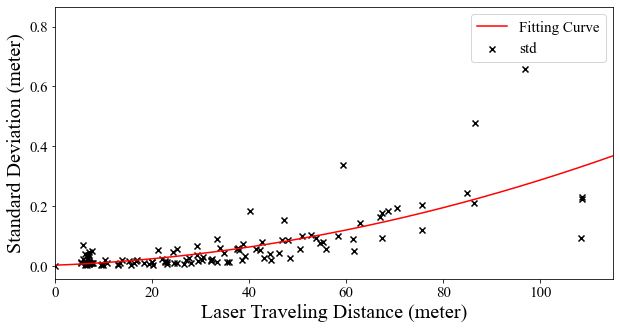

In [6]:
plt.figure(figsize=(10,5))
plt.scatter(dis_Total,stds_Total, marker = 'x', c = 'black', label = 'std')
plt.plot(x,y , c = 'r' , label = 'Fitting Curve')
plt.xlim(0,115)
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel('Laser Traveling Distance (meter)',fontsize = 20)
plt.ylabel('Standard Deviation (meter)',fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\distance.tif',dpi = 600)
plt.show()

In [61]:
x = np.arange(1,140,10)
y = popt[0] * x**2 + popt[1] * x + popt[2]

In [32]:
f_path = r'D:\LiDAR_Data\AmplitudeTest\Liberty\Snowy'
path_amp = os.listdir(f_path)
dis_Liberty = []
amps = []
for p in path_amp:
    test = np.load(os.path.join(f_path,p))
    dis_Liberty.append(eval(p[:-4]))
    amps.append(test)
stds_Liberty = np.array([a.std() for a in amps])
# means = [a.mean() for a in amps]
lenths_Liberty = np.array([len(a) for a in amps])
dis_Liberty = np.array(dis_Liberty)
f_path = r'D:\LiDAR_Data\AmplitudeTest\Steward\Snowy'
path_amp = os.listdir(f_path)
dis_Steward = []
amps = []
for p in path_amp:
    test = np.load(os.path.join(f_path,p))
    dis_Steward.append(eval(p[:-4]))
    amps.append(test)
stds_Steward = np.array([a.std() for a in amps])
# means = [a.mean() for a in amps]
lenths_Steward = np.array([len(a) for a in amps])
dis_Steward = np.array(dis_Steward)
f_path = r'D:\LiDAR_Data\AmplitudeTest\California\Snowy'
path_amp = os.listdir(f_path)
dis_California = []
amps = []
for p in path_amp:
    test = np.load(os.path.join(f_path,p))
    dis_California.append(eval(p[:-4]))
    amps.append(test)
stds_California = np.array([a.std() for a in amps])
lenths_California = np.array([len(a) for a in amps])
dis_California = np.array(dis_California)

In [23]:
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * np.e**x + b 

In [28]:
popt, pcov = curve_fit(func, total_dis, total_std)
x = np.arange(0,180)
y = popt[0] * np.e**x + popt[1]

In [29]:
x = np.arange(0,180)
y = popt[0] * np.e**x + popt[1]

In [30]:
total_dis = np.concatenate([dis_Liberty,dis_Steward,dis_California])
total_std = np.concatenate([stds_Liberty,stds_Steward,stds_California])

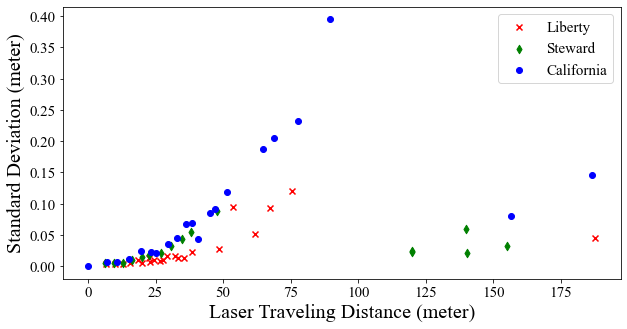

In [39]:
plt.figure(figsize=(10,5))
plt.scatter(dis_Liberty[lenths_Liberty > 10000],stds_Liberty[lenths_Liberty > 10000], marker = 'x', c = 'r',label = 'Liberty')
plt.scatter(dis_Steward[lenths_Steward > 10000],stds_Steward[lenths_Steward > 10000], marker = 'd', c = 'g',label = 'Steward')
plt.scatter(dis_California[lenths_California > 10000],stds_California[lenths_California > 10000], marker = 'o', c = 'b',label = 'California')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
# plt.plot(x,y)
# plt.ylim(0,0.3)
plt.xlabel('Laser Traveling Distance (meter)',fontsize = 20)
plt.ylabel('Standard Deviation (meter)',fontsize = 20)
plt.show()

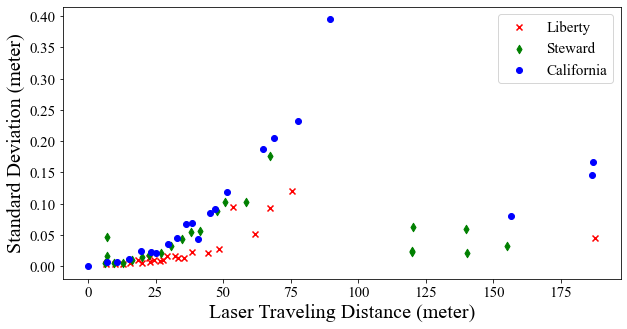

In [36]:
f_path = r'D:\LiDAR_Data\AmplitudeTest\Liberty\Normal'
path_amp = os.listdir(f_path)
dis_Liberty = []
amps = []
for p in path_amp:
    test = np.load(os.path.join(f_path,p))
    dis_Liberty.append(eval(p[:-4]))
    amps.append(test)
stds_Liberty = np.array([a.std() for a in amps])
# means = [a.mean() for a in amps]
lenths_Liberty = np.array([len(a) for a in amps])
dis_Liberty = np.array(dis_Liberty)
f_path = r'D:\LiDAR_Data\AmplitudeTest\Steward\Normal'
path_amp = os.listdir(f_path)
dis_Steward = []
amps = []
for p in path_amp:
    test = np.load(os.path.join(f_path,p))
    dis_Steward.append(eval(p[:-4]))
    amps.append(test)
stds_Steward = np.array([a.std() for a in amps])
# means = [a.mean() for a in amps]
lenths_Steward = np.array([len(a) for a in amps])
dis_Steward = np.array(dis_Steward)
f_path = r'D:\LiDAR_Data\AmplitudeTest\California\Normal'
path_amp = os.listdir(f_path)
dis_California = []
amps = []
for p in path_amp:
    test = np.load(os.path.join(f_path,p))
    dis_California.append(eval(p[:-4]))
    amps.append(test)
stds_California = np.array([a.std() for a in amps])
lenths_California = np.array([len(a) for a in amps])
dis_California = np.array(dis_California)
plt.figure(figsize=(10,5))
plt.scatter(dis_Liberty[lenths_Liberty > 8000],stds_Liberty[lenths_Liberty > 8000], marker = 'x', c = 'r',label = 'Liberty')
plt.scatter(dis_Steward[lenths_Steward > 8000],stds_Steward[lenths_Steward > 8000], marker = 'd', c = 'g',label = 'Steward')
plt.scatter(dis_California[lenths_California > 8000],stds_California[lenths_California > 8000], marker = 'o', c = 'b',label = 'California')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
# plt.plot(x,y)
# plt.ylim(0,0.3)
plt.xlabel('Laser Traveling Distance (meter)',fontsize = 20)
plt.ylabel('Standard Deviation (meter)',fontsize = 20)
plt.show()

In [703]:
temp = amps[5].copy()
temp = temp[temp < 160]

In [705]:
np.save(r'D:\LiDAR_Data\AmplitudeTest\California\Normal\{}.npy'.format(dis[5]),temp)

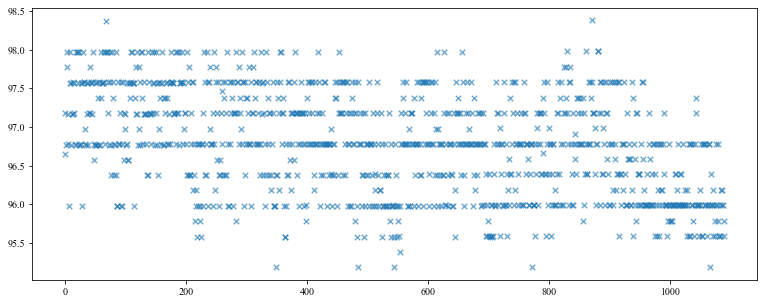

In [724]:
plt.figure(figsize=(13,5))
plt.scatter(np.arange(len(amps[36])),amps[36],s = 30, marker = 'x', label = "Background", alpha = 0.6)

In [80]:
vol_weekday = pd.read_csv(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Data\weekday.csv')
vol_weekend = pd.read_csv(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Data\weekend.csv')

In [81]:
SB_weekday = np.array(vol_weekday.S)/3600
NB_weekday = np.array(vol_weekday.N)/3600

In [82]:
SB_weekend = np.array(vol_weekend.S)/3600
NB_weekend = np.array(vol_weekend.N)/3600

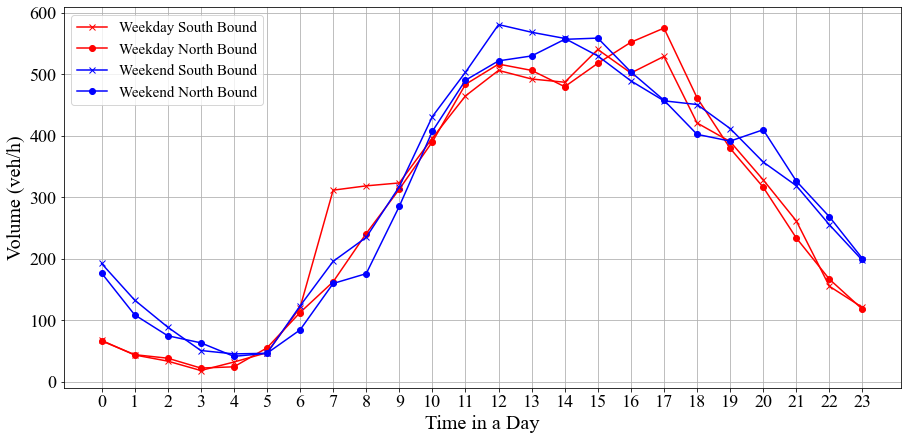

In [4]:
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(vol_weekday.S, c = 'r', marker = 'x', label = 'Weekday South Bound')
plt.plot(vol_weekday.N, c = 'r', marker = 'o', label = 'Weekday North Bound')
plt.plot(vol_weekend.S, c = 'b', marker = 'x', label = 'Weekend South Bound')
plt.plot(vol_weekend.N, c = 'b', marker = 'o', label = 'Weekend North Bound')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Volume (veh/h)',fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\volumes.tif',dpi = 300)
plt.show()

In [17]:
f_path = r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Data\Result_WeekEnd'
foregrounds_NBTD = []
p_f_NBTD = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_NBTD.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 34)]
    foregrounds_NBTD.append(fore)
    p_f_NBTD.append(len(fore)/len(temp))
foregrounds_NBTU = []
p_f_NBTU = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_NBTU.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 12.5)]
    foregrounds_NBTU.append(fore)
    p_f_NBTU.append(len(fore)/len(temp))
foregrounds_SBTU = []
p_f_SBTU = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_SBTU.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 35)]
    foregrounds_NBTU.append(fore)
    p_f_SBTU.append(len(fore)/len(temp))
foregrounds_SBTD = []
p_f_SBTD = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_SBTD.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 20)]
    p_f_SBTD.append(len(fore)/len(temp))

In [110]:
speed = 20.2*1000/3600
ro_SBTU_weekend = 5*(SB_weekend/speed)
speed = 30.3*1000/3600
ro_SBTD_weekend = 5*(SB_weekend/speed)

In [77]:
np.abs((ro_SBTD_weekend - p_f_SBTD)).sum()/24

0.009984922673482699

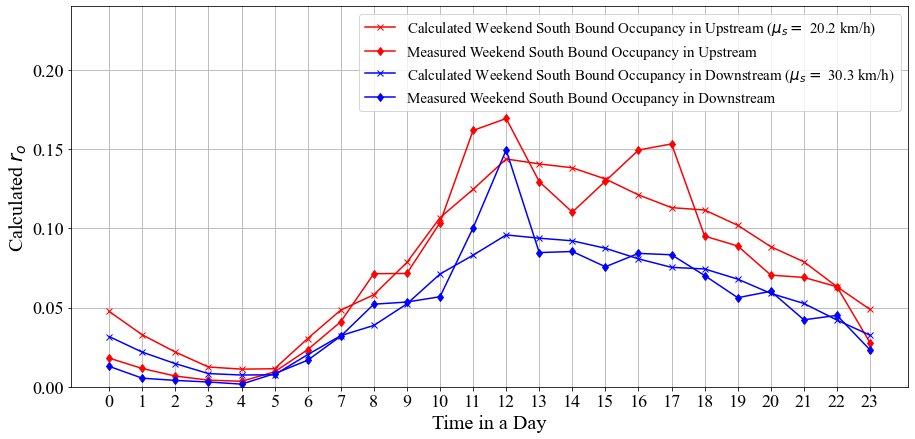

In [111]:
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(ro_SBTU_weekend, c = 'r', marker = 'x', label = 'Calculated Weekend South Bound Occupancy in Upstream ($ \mathit{\mu_s} = $ 20.2 km/h)')
plt.plot(p_f_SBTU, c = 'r', marker = 'd', label = 'Measured Weekend South Bound Occupancy in Upstream')
plt.plot(ro_SBTD_weekend, c = 'b', marker = 'x', label = 'Calculated Weekend South Bound Occupancy in Downstream ($ \mathit{\mu_s} = $ 30.3 km/h)')
plt.plot(p_f_SBTD, c = 'b', marker = 'd', label = 'Measured Weekend South Bound Occupancy in Downstream')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.24)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Calculated $r_o$ ',fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roSB_weekend.tif',dpi = 300)
plt.show()

In [78]:
np.abs((ro_NBTD_weekend - p_f_NBTD)).sum()/24

0.009536208469823408

In [79]:
np.abs((ro_NBTU_weekend - p_f_NBTU)).sum()/24

0.026884370694428766

In [83]:
speed = 13.8*1000/3600
ro_NBTU_weekend = 5*(NB_weekend/speed)
speed = 34.1*1000/3600
ro_NBTD_weekend = 5*(NB_weekend/speed)

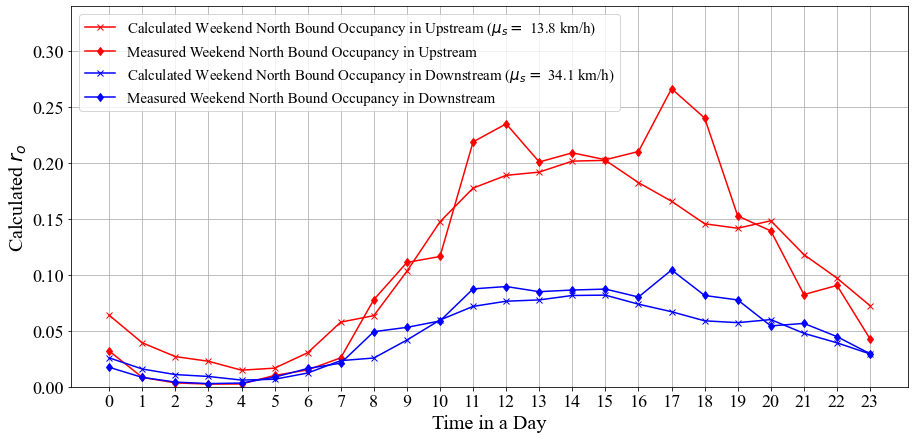

In [109]:
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(ro_NBTU_weekend, c = 'r', marker = 'x', label = 'Calculated Weekend North Bound Occupancy in Upstream ($ \mathit{\mu_s} = $ 13.8 km/h)')
plt.plot(p_f_NBTU, c = 'r', marker = 'd', label = 'Measured Weekend North Bound Occupancy in Upstream')
plt.plot(ro_NBTD_weekend, c = 'b', marker = 'x', label = 'Calculated Weekend North Bound Occupancy in Downstream ($ \mathit{\mu_s} = $ 34.1 km/h)')
plt.plot(p_f_NBTD, c = 'b', marker = 'd', label = 'Measured Weekend North Bound Occupancy in Downstream')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.34)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Calculated $r_o$',fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roNB_weekend.tif',dpi = 300)

plt.show()

In [4]:
f_path = r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Data\Result_WeekDay'
foregrounds_NBTD = []
p_f_NBTD = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_NBTD.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 34)]
    foregrounds_NBTD.append(fore)
    p_f_NBTD.append(len(fore)/len(temp))
foregrounds_NBTU = []
p_f_NBTU = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_NBTU.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 12.5)]
    foregrounds_NBTU.append(fore)
    p_f_NBTU.append(len(fore)/len(temp))
foregrounds_SBTU = []
p_f_SBTU = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_SBTU.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 35)]
    foregrounds_NBTU.append(fore)
    p_f_SBTU.append(len(fore)/len(temp))
foregrounds_SBTD = []
p_f_SBTD = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_SBTD.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 20)]
    p_f_SBTD.append(len(fore)/len(temp))

In [84]:
speed = 21.5*1000/3600
ro_SBTU_weekday = 5*(SB_weekday/speed)
speed = 30.6*1000/3600
ro_SBTD_weekday = 5*(SB_weekday/speed)

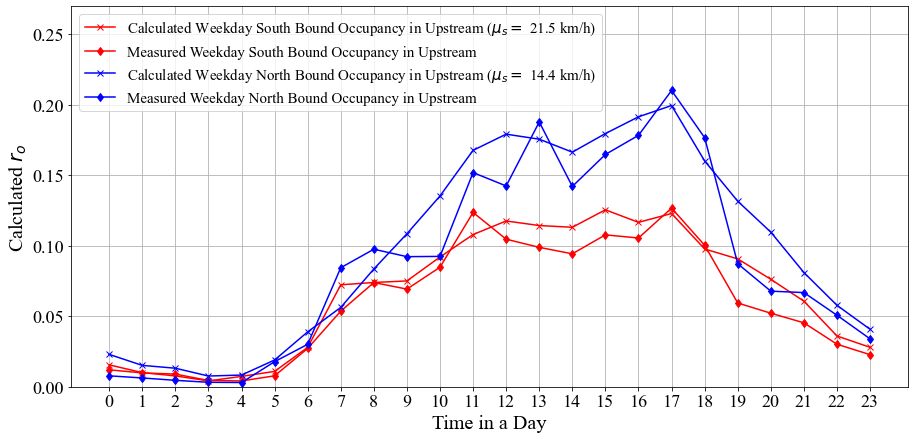

In [18]:
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(ro_SBTU_weekday, c = 'r', marker = 'x', label = 'Calculated Weekday South Bound Occupancy in Upstream ($ \mathit{\mu_s} = $ 21.5 km/h)')
plt.plot(p_f_SBTU, c = 'r', marker = 'd', label = 'Measured Weekday South Bound Occupancy in Upstream')
plt.plot(ro_NBTU_weekday, c = 'b', marker = 'x', label = 'Calculated Weekday North Bound Occupancy in Upstream ($ \mathit{\mu_s} = $ 14.4 km/h)')
plt.plot(p_f_NBTU, c = 'b', marker = 'd', label = 'Measured Weekday North Bound Occupancy in Upstream')
# plt.plot(ro_SBTD_weekday, c = 'b', marker = 'x', label = 'Calculated Weekday South Bound Occupancy in Downstream ($ \mathit{\mu_s} = $ 30.6 km/h)')
# plt.plot(p_f_SBTD, c = 'b', marker = 'd', label = 'Measured Weekday South Bound Occupancy in Downstream')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.27)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Calculated $r_o$ ',fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\ro_final.tif',dpi = 300)
plt.show()

In [85]:
speed = 14.4*1000/3600
ro_NBTU_weekday = 5*(NB_weekday/speed)
speed = 34.6*1000/3600
ro_NBTD_weekday = 5*(NB_weekday/speed)

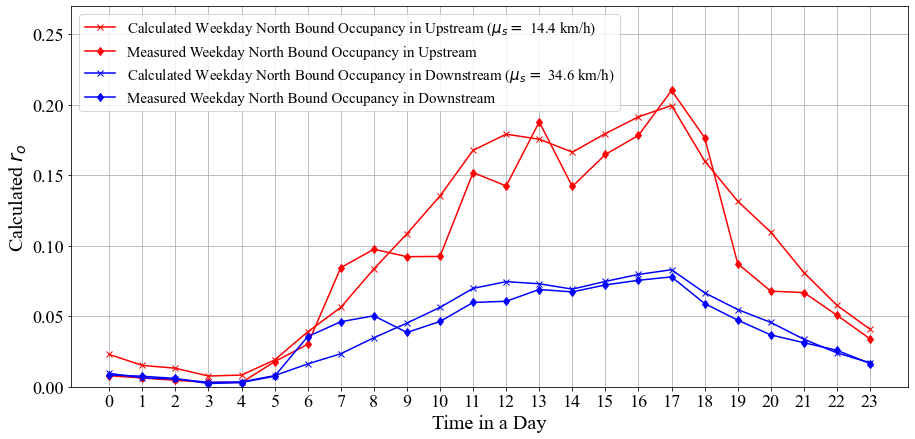

In [116]:

plt.figure(figsize=(15,7))
plt.grid()
plt.plot(ro_NBTU_weekday, c = 'r', marker = 'x', label = 'Calculated Weekday North Bound Occupancy in Upstream ($ \mathit{\mu_s} = $ 14.4 km/h)')
plt.plot(p_f_NBTU, c = 'r', marker = 'd', label = 'Measured Weekday North Bound Occupancy in Upstream')
plt.plot(ro_NBTD_weekday, c = 'b', marker = 'x', label = 'Calculated Weekday North Bound Occupancy in Downstream ($ \mathit{\mu_s} = $ 34.6 km/h)')
plt.plot(p_f_NBTD, c = 'b', marker = 'd', label = 'Measured Weekday North Bound Occupancy in Downstream')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.27)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Calculated $r_o$ ',fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roNB_weekday.tif',dpi = 300)
plt.show()

In [98]:
f_path = r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Data\Result_WeekEnd'
foregrounds_NBTD = []
p_f_NBTD = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_NBTD.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 34)]
    foregrounds_NBTD.append(fore)
    p_f_NBTD.append(len(fore)/len(temp))
foregrounds_NBTU = []
p_f_NBTU = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_NBTU.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 12.5)]
    foregrounds_NBTU.append(fore)
    p_f_NBTU.append(len(fore)/len(temp))
foregrounds_SBTU = []
p_f_SBTU = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_SBTU.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 35)]
    foregrounds_NBTU.append(fore)
    p_f_SBTU.append(len(fore)/len(temp))
foregrounds_SBTD = []
p_f_SBTD = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_SBTD.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 20)]
    p_f_SBTD.append(len(fore)/len(temp))

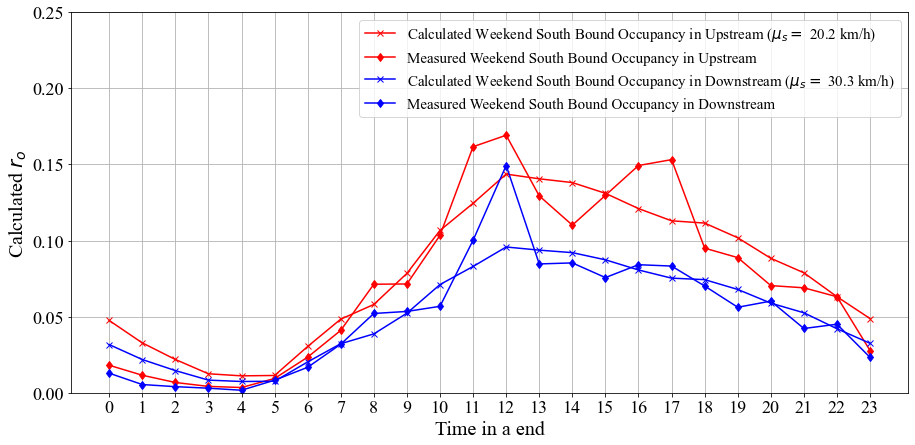

In [103]:
speed = 20.2*1000/3600
ro_SBTU_weekend = 5*(SB_weekend/speed)
speed = 30.3*1000/3600
ro_SBTD_weekend = 5*(SB_weekend/speed)
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(ro_SBTU_weekend, c = 'r', marker = 'x', label = 'Calculated Weekend South Bound Occupancy in Upstream ($ \mathit{\mu_s} = $ 20.2 km/h)')
plt.plot(p_f_SBTU, c = 'r', marker = 'd', label = 'Measured Weekend South Bound Occupancy in Upstream')
plt.plot(ro_SBTD_weekend, c = 'b', marker = 'x', label = 'Calculated Weekend South Bound Occupancy in Downstream ($ \mathit{\mu_s} = $ 30.3 km/h)')
plt.plot(p_f_SBTD, c = 'b', marker = 'd', label = 'Measured Weekend South Bound Occupancy in Downstream')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.25)
plt.xlabel('Time in a end',fontsize = 20)
plt.ylabel('Calculated $r_o$ ',fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roSB_weekend.tif',dpi = 300)
plt.show()

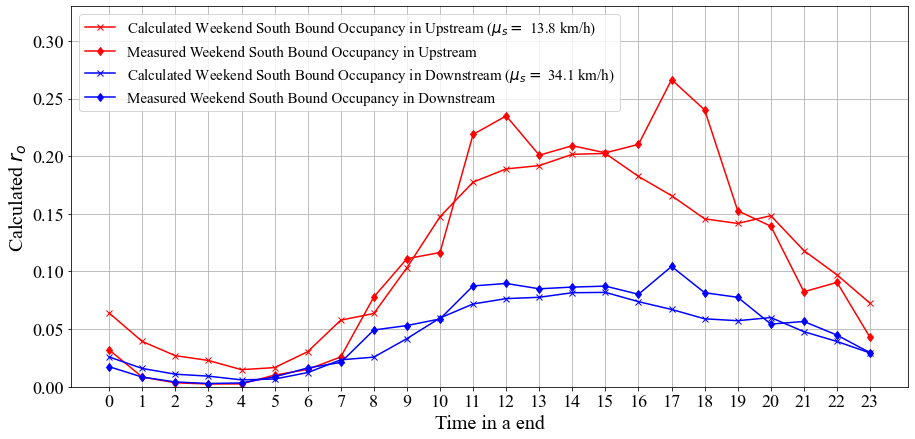

In [107]:
speed = 13.8*1000/3600
ro_NBTU_weekend = 5*(NB_weekend/speed)
speed = 34.1*1000/3600
ro_NBTD_weekend = 5*(NB_weekend/speed)
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(ro_NBTU_weekend, c = 'r', marker = 'x', label = 'Calculated Weekend South Bound Occupancy in Upstream ($ \mathit{\mu_s} = $ 13.8 km/h)')
plt.plot(p_f_NBTU, c = 'r', marker = 'd', label = 'Measured Weekend South Bound Occupancy in Upstream')
plt.plot(ro_NBTD_weekend, c = 'b', marker = 'x', label = 'Calculated Weekend South Bound Occupancy in Downstream ($ \mathit{\mu_s} = $ 34.1 km/h)')
plt.plot(p_f_NBTD, c = 'b', marker = 'd', label = 'Measured Weekend South Bound Occupancy in Downstream')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.33)
plt.xlabel('Time in a end',fontsize = 20)
plt.ylabel('Calculated $r_o$ ',fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roNB_weekend.tif',dpi = 300)
plt.show()

In [19]:
c_f = 0.16

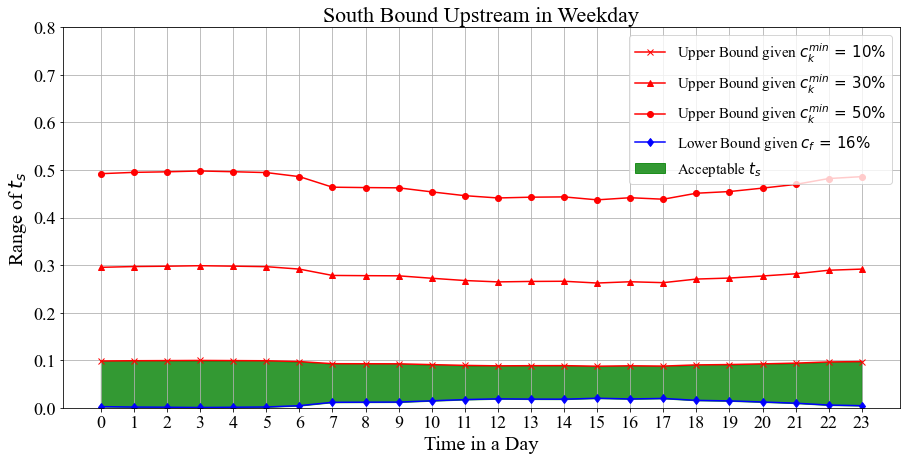

In [20]:
ro_SBTU_weekday
lower_SBTU_weekday = c_f * ro_SBTU_weekday
upper_SBTU_weekday_1 = 0.1*(1 - ro_SBTU_weekday)
upper_SBTU_weekday_3 = 0.3*(1 - ro_SBTU_weekday)
upper_SBTU_weekday_5 = 0.5*(1 - ro_SBTU_weekday)
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(upper_SBTU_weekday_1, c = 'r', marker = 'x', label = 'Upper Bound given $c_k^{min}\/=\/10\%$')
plt.plot(upper_SBTU_weekday_3, c = 'r', marker = '^', label = 'Upper Bound given $c_k^{min}\/=\/30\%$')
plt.plot(upper_SBTU_weekday_5, c = 'r', marker = 'o', label = 'Upper Bound given $c_k^{min}\/=\/50\%$')
plt.plot(lower_SBTU_weekday, c = 'b', marker = 'd', label = 'Lower Bound given $c_f\/=\/16\%$ ')
plt.fill_between(np.arange(24),upper_SBTU_weekday_1,lower_SBTU_weekday, color = 'g', label = 'Acceptable $t_s$',alpha = 0.8)
plt.legend(fontsize = 15, loc = 'upper right')
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.8)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.title('South Bound Upstream in Weekday', fontsize = 22)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roSBTU_ts_weekday.tif',dpi = 300)
plt.show()

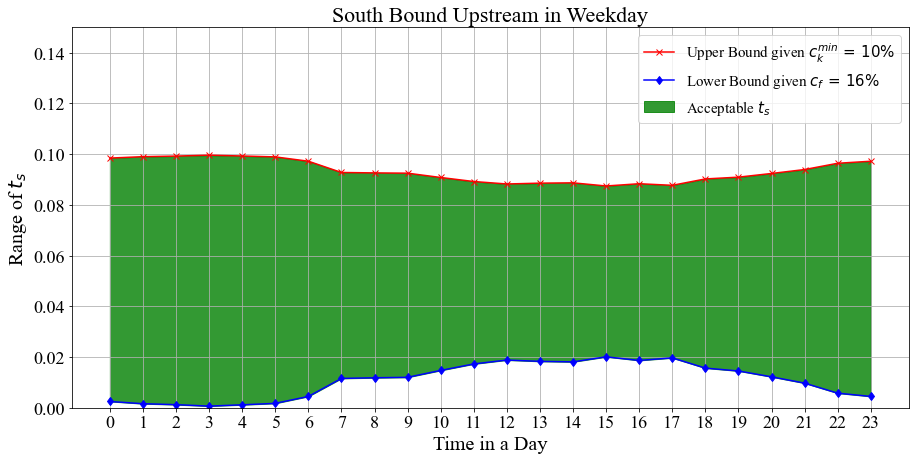

In [21]:
ro_SBTU_weekday
lower_SBTU_weekday = c_f * ro_SBTU_weekday
upper_SBTU_weekday_1 = 0.1*(1 - ro_SBTU_weekday)
upper_SBTU_weekday_3 = 0.3*(1 - ro_SBTU_weekday)
upper_SBTU_weekday_5 = 0.5*(1 - ro_SBTU_weekday)
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(upper_SBTU_weekday_1, c = 'r', marker = 'x', label = 'Upper Bound given $c_k^{min}\/=\/10\%$')
# plt.plot(upper_SBTU_weekday_3, c = 'r', marker = '^', label = 'Upper Bound given $c_k^{min}\/=\/30\%$')
# plt.plot(upper_SBTU_weekday_5, c = 'r', marker = 'o', label = 'Upper Bound given $c_k^{min}\/=\/50\%$')
plt.plot(lower_SBTU_weekday, c = 'b', marker = 'd', label = 'Lower Bound given $c_f\/=\/16\%$ ')
plt.fill_between(np.arange(24),upper_SBTU_weekday_1,lower_SBTU_weekday, color = 'g', label = 'Acceptable $t_s$',alpha = 0.8)
plt.legend(fontsize = 15, loc = 'upper right')
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.15)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.title('South Bound Upstream in Weekday', fontsize = 22)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roSBTU_ts_weekday_zoomin.tif',dpi = 300)
plt.show()

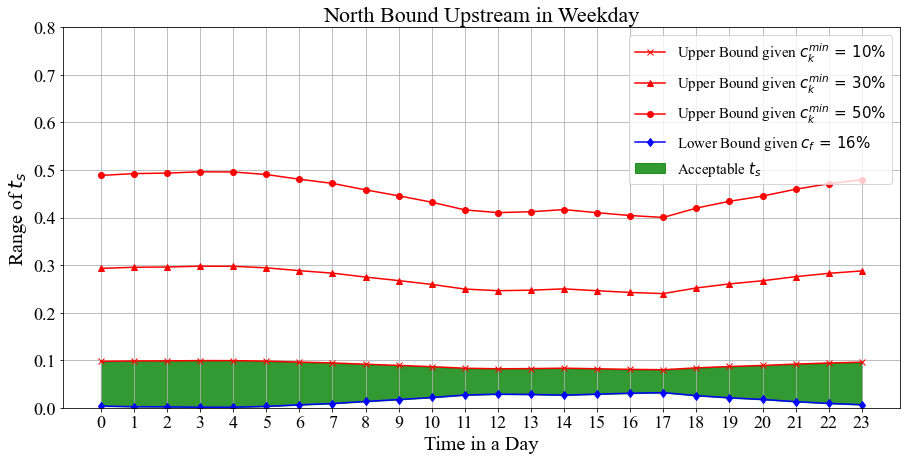

In [22]:
ro_NBTU_weekday
lower_NBTU_weekday = c_f * ro_NBTU_weekday
upper_NBTU_weekday_1 = 0.1*(1 - ro_NBTU_weekday)
upper_NBTU_weekday_3 = 0.3*(1 - ro_NBTU_weekday)
upper_NBTU_weekday_5 = 0.5*(1 - ro_NBTU_weekday)
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(upper_NBTU_weekday_1, c = 'r', marker = 'x', label = 'Upper Bound given $c_k^{min}\/=\/10\%$')
plt.plot(upper_NBTU_weekday_3, c = 'r', marker = '^', label = 'Upper Bound given $c_k^{min}\/=\/30\%$')
plt.plot(upper_NBTU_weekday_5, c = 'r', marker = 'o', label = 'Upper Bound given $c_k^{min}\/=\/50\%$')
plt.plot(lower_NBTU_weekday, c = 'b', marker = 'd', label = 'Lower Bound given $c_f\/=\/16\%$ ')
plt.fill_between(np.arange(24),upper_NBTU_weekday_1,lower_NBTU_weekday, color = 'g', label = 'Acceptable $t_s$',alpha = 0.8)
plt.legend(fontsize = 15, loc = 'upper right')
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.8)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.title('North Bound Upstream in Weekday', fontsize = 22)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roNBTU_ts_weekday.tif',dpi = 300)
plt.show()

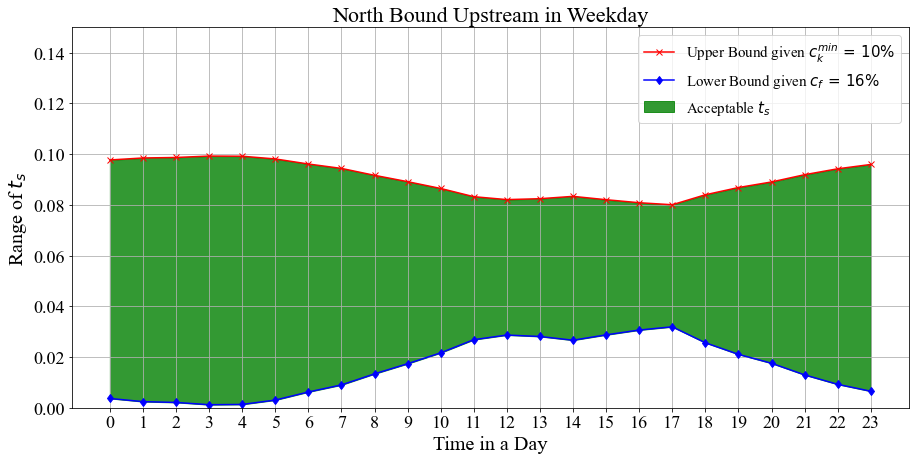

In [23]:
ro_NBTU_weekday
lower_NBTU_weekday = c_f * ro_NBTU_weekday
upper_NBTU_weekday_1 = 0.1*(1 - ro_NBTU_weekday)
upper_NBTU_weekday_3 = 0.3*(1 - ro_NBTU_weekday)
upper_NBTU_weekday_5 = 0.5*(1 - ro_NBTU_weekday)
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(upper_NBTU_weekday_1, c = 'r', marker = 'x', label = 'Upper Bound given $c_k^{min}\/=\/10\%$')
# plt.plot(upper_NBTU_weekday_3, c = 'r', marker = '^', label = 'Upper Bound given $c_k^{min}\/=\/30\%$')
# plt.plot(upper_NBTU_weekday_5, c = 'r', marker = 'o', label = 'Upper Bound given $c_k^{min}\/=\/50\%$')
plt.plot(lower_NBTU_weekday, c = 'b', marker = 'd', label = 'Lower Bound given $c_f\/=\/16\%$ ')
plt.fill_between(np.arange(24),upper_NBTU_weekday_1,lower_NBTU_weekday, color = 'g', label = 'Acceptable $t_s$',alpha = 0.8)
plt.legend(fontsize = 15, loc = 'upper right')
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.15)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.title('North Bound Upstream in Weekday', fontsize = 22)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roNBTU_ts_weekday_zoomin.tif',dpi = 300)
plt.show()

In [20]:
adopted_ts

array([0.0506901 , 0.05045573, 0.05039583, 0.05022917, 0.05025   ,
       0.05057031, 0.05116927, 0.05217151, 0.05250781, 0.05325781,
       0.0540625 , 0.05503385, 0.0553776 , 0.05527083, 0.05499479,
       0.05539062, 0.0557474 , 0.05598698, 0.05480729, 0.05395052,
       0.05329167, 0.05243229, 0.05173437, 0.05122396])

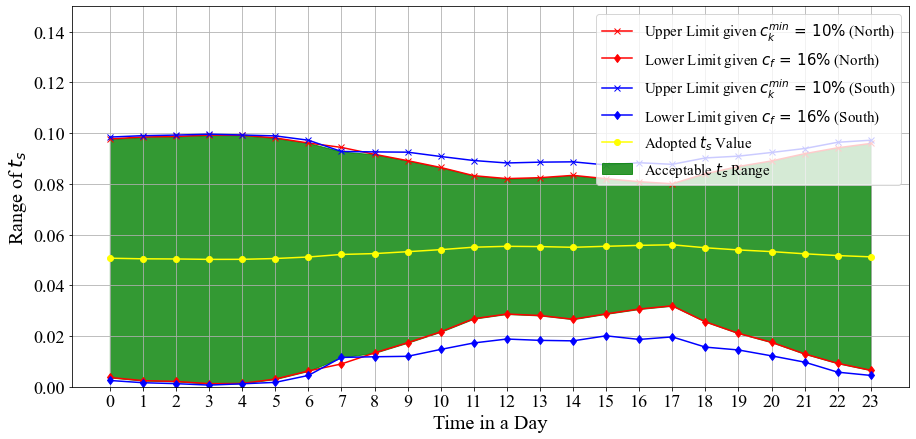

In [87]:
c_f = 0.16
lower_NBTU_weekday = c_f * ro_NBTU_weekday
upper_NBTU_weekday_1 = 0.1*(1 - ro_NBTU_weekday)
lower_SBTU_weekday = c_f * ro_SBTU_weekday
upper_SBTU_weekday_1 = 0.1*(1 - ro_SBTU_weekday)
ts_region_upper = []
for i in range(len(upper_NBTU_weekday_1)):
    if upper_NBTU_weekday_1[i] < upper_SBTU_weekday_1[i]:
        ts_region_upper.append(upper_NBTU_weekday_1[i])
    else:
        ts_region_upper.append(upper_SBTU_weekday_1[i])
ts_region_lower = []
for i in range(len(lower_NBTU_weekday)):
    if lower_SBTU_weekday[i] < lower_NBTU_weekday[i]:
        ts_region_lower.append(lower_NBTU_weekday[i])
    else:
        ts_region_lower.append(lower_SBTU_weekday[i])      
adopted_ts = (np.array(ts_region_lower) + np.array(ts_region_upper))/2
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(upper_NBTU_weekday_1, c = 'r', marker = 'x', label = 'Upper Limit given $c_k^{min}\/=\/10\%$ (North)')
plt.plot(lower_NBTU_weekday, c = 'r', marker = 'd', label = 'Lower Limit given $c_f\/=\/16\%$ (North)')
plt.plot(upper_SBTU_weekday_1, c = 'b', marker = 'x', label = 'Upper Limit given $c_k^{min}\/=\/10\%$ (South)')
plt.plot(lower_SBTU_weekday, c = 'b', marker = 'd', label = 'Lower Limit given $c_f\/=\/16\%$ (South)')
plt.fill_between(np.arange(24),ts_region_upper,ts_region_lower, color = 'g', label = 'Acceptable $t_s$ Range',alpha = 0.8)
plt.plot(adopted_ts, marker = 'o',c  = 'yellow', label = 'Adopted $t_s$ Value')
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.ylim(0,0.15)
plt.legend(fontsize = 15,)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\FinalTs.tif',dpi = 300)

plt.show()

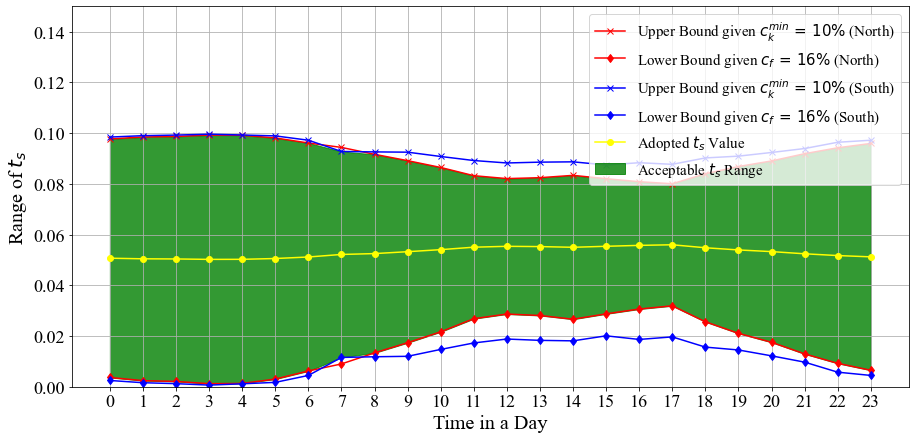

In [19]:
c_f = 0.16
lower_NBTU_weekday = c_f * ro_NBTU_weekday
upper_NBTU_weekday_1 = 0.1*(1 - ro_NBTU_weekday)
lower_SBTU_weekday = c_f * ro_SBTU_weekday
upper_SBTU_weekday_1 = 0.1*(1 - ro_SBTU_weekday)
ts_region_upper = []
for i in range(len(upper_NBTU_weekday_1)):
    if upper_NBTU_weekday_1[i] < upper_SBTU_weekday_1[i]:
        ts_region_upper.append(upper_NBTU_weekday_1[i])
    else:
        ts_region_upper.append(upper_SBTU_weekday_1[i])
ts_region_lower = []
for i in range(len(lower_NBTU_weekday)):
    if lower_SBTU_weekday[i] < lower_NBTU_weekday[i]:
        ts_region_lower.append(lower_NBTU_weekday[i])
    else:
        ts_region_lower.append(lower_SBTU_weekday[i])      
adopted_ts = (np.array(ts_region_lower) + np.array(ts_region_upper))/2
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(upper_NBTU_weekday_1, c = 'r', marker = 'x', label = 'Upper Bound given $c_k^{min}\/=\/10\%$ (North)')
plt.plot(lower_NBTU_weekday, c = 'r', marker = 'd', label = 'Lower Bound given $c_f\/=\/16\%$ (North)')
plt.plot(upper_SBTU_weekday_1, c = 'b', marker = 'x', label = 'Upper Bound given $c_k^{min}\/=\/10\%$ (South)')
plt.plot(lower_SBTU_weekday, c = 'b', marker = 'd', label = 'Lower Bound given $c_f\/=\/16\%$ (South)')
plt.fill_between(np.arange(24),ts_region_upper,ts_region_lower, color = 'g', label = 'Acceptable $t_s$ Range',alpha = 0.8)
plt.plot(adopted_ts, marker = 'o',c  = 'yellow', label = 'Adopted $t_s$ Value')
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.ylim(0,0.15)
plt.legend(fontsize = 15,)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\FinalTs.tif',dpi = 300)

plt.show()

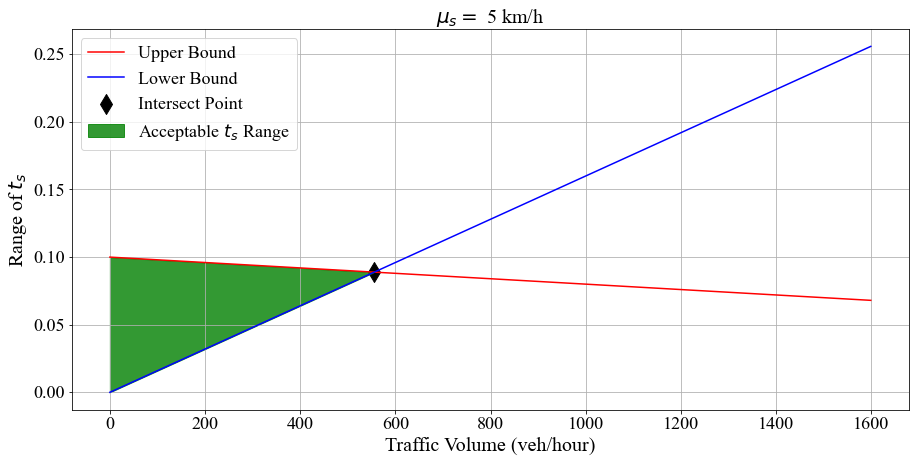

In [188]:
vkm = 5
v = vkm*1000/3600
L = 5
cf = 0.16
q = np.arange(0,1600,1)/3600
ckmin = 0.1
lower_bound = cf * L * q / v 
upper_bound = ckmin * (1 - q/v)
x_lim = ckmin*v/(cf*L +ckmin)* 3600
y_lim = cf * L * ckmin /(cf*L + ckmin)
plt.figure(figsize=(15,7))
plt.grid()
plt.scatter(x_lim ,y_lim, c = 'black', s = 200, marker = 'd',label = 'Intersect Point')
plt.plot(upper_bound, c = 'r' ,label = 'Upper Bound')
plt.plot(lower_bound, c = 'b', label = 'Lower Bound')
plt.fill_between(np.arange(0,int(x_lim)),upper_bound[:int(x_lim)],lower_bound[:int(x_lim)], color = 'g', label = 'Acceptable $t_s$ Range',alpha = 0.8)
plt.xlabel('Traffic Volume (veh/hour)',fontsize = 20)
plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.legend(fontsize = 18)
plt.title(r'$ \mathit{\mu_s} = $ 5 km/h', fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\FinalTs_5.tif',dpi = 300)


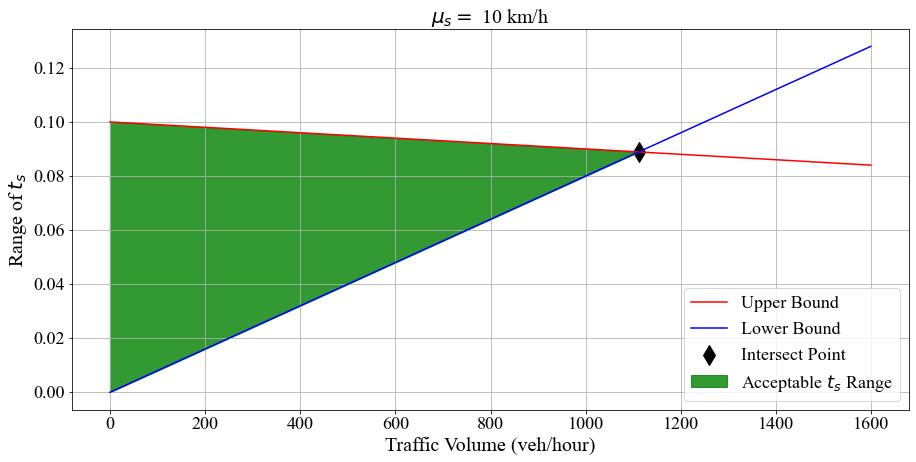

In [189]:
vkm = 10
v = vkm*1000/3600
L = 5
cf = 0.16
q = np.arange(0,1600,1)/3600
ckmin = 0.1
lower_bound = cf * L * q / v 
upper_bound = ckmin * (1 - q/v)
x_lim = ckmin*v/(cf*L +ckmin)* 3600
y_lim = cf * L * ckmin /(cf*L + ckmin)
plt.figure(figsize=(15,7))
plt.grid()
plt.scatter(x_lim ,y_lim, c = 'black', s = 200, marker = 'd',label = 'Intersect Point')
plt.plot(upper_bound, c = 'r' ,label = 'Upper Bound')
plt.plot(lower_bound, c = 'b', label = 'Lower Bound')
plt.fill_between(np.arange(0,int(x_lim)),upper_bound[:int(x_lim)],lower_bound[:int(x_lim)], color = 'g', label = 'Acceptable $t_s$ Range',alpha = 0.8)
plt.xlabel('Traffic Volume (veh/hour)',fontsize = 20)
plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.legend(fontsize = 18)
plt.title(r'$ \mathit{\mu_s} = $ 10 km/h', fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\FinalTs_10.tif',dpi = 300)


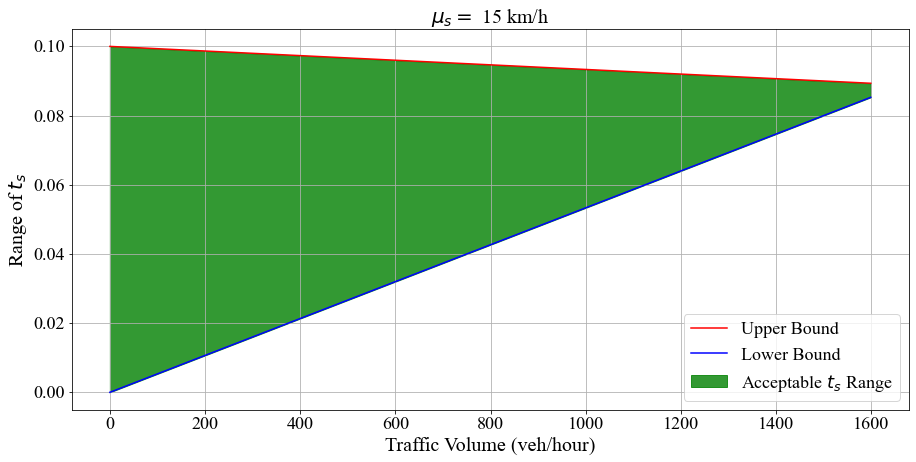

In [191]:
vkm = 15
v = vkm*1000/3600
L = 5
cf = 0.16
q = np.arange(0,1600,1)/3600
ckmin = 0.1
lower_bound = cf * L * q / v 
upper_bound = ckmin * (1 - q/v)
x_lim = ckmin*v/(cf*L +ckmin)* 3600
y_lim = cf * L * ckmin /(cf*L + ckmin)
plt.figure(figsize=(15,7))
plt.grid()
# plt.scatter(x_lim ,y_lim, c = 'black', s = 200, marker = 'd',label = 'Intersect Point')
plt.plot(upper_bound, c = 'r' ,label = 'Upper Bound')
plt.plot(lower_bound, c = 'b', label = 'Lower Bound')
plt.fill_between(np.arange(len(q)),upper_bound,lower_bound, color = 'g', label = 'Acceptable $t_s$ Range',alpha = 0.8)
plt.xlabel('Traffic Volume (veh/hour)',fontsize = 20)
plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.legend(fontsize = 18)
plt.title(r'$ \mathit{\mu_s} = $ 15 km/h', fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\FinalTs_15.tif',dpi = 300)


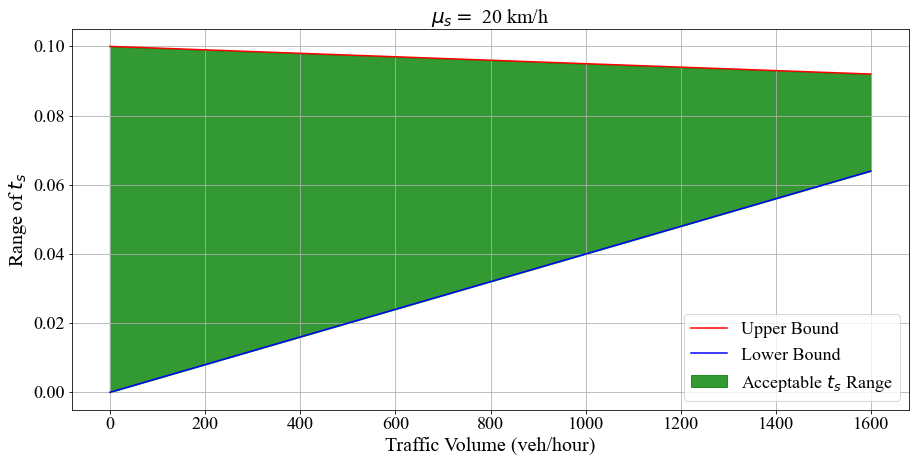

In [193]:
vkm = 20
v = vkm*1000/3600
L = 5
cf = 0.16
q = np.arange(0,1600,1)/3600
ckmin = 0.1
lower_bound = cf * L * q / v 
upper_bound = ckmin * (1 - q/v)
x_lim = ckmin*v/(cf*L +ckmin)* 3600
y_lim = cf * L * ckmin /(cf*L + ckmin)
plt.figure(figsize=(15,7))
plt.grid()
# plt.scatter(x_lim ,y_lim, c = 'black', s = 200, marker = 'd',label = 'Intersect Point')
plt.plot(upper_bound, c = 'r' ,label = 'Upper Bound')
plt.plot(lower_bound, c = 'b', label = 'Lower Bound')
plt.fill_between(np.arange(len(q)),upper_bound,lower_bound, color = 'g', label = 'Acceptable $t_s$ Range',alpha = 0.8)
plt.xlabel('Traffic Volume (veh/hour)',fontsize = 20)
plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.legend(fontsize = 18)
plt.title(r'$ \mathit{\mu_s} = $ 20 km/h', fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\FinalTs_20.tif',dpi = 300)


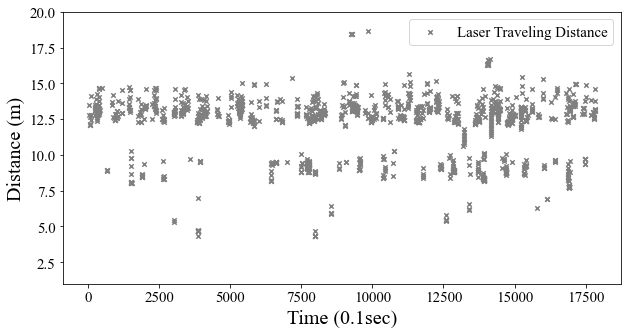

0.04416065951546039


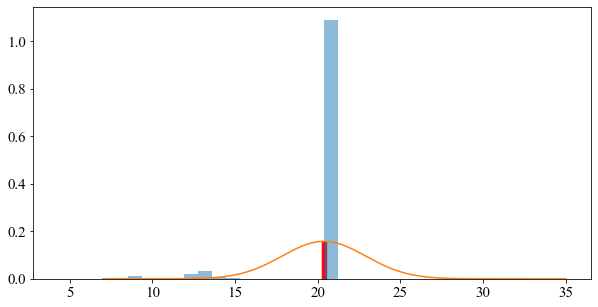

In [33]:
temp = np.load(os.path.join(f_path,'{}_SBTD.npy'.format(14)))
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
fore = temp[(temp > 1)&(temp < 35.5)]
plt.ylim(1,20)
plt.show()
plt.figure(figsize=(10,5))
plt.hist(fore,density = True,bins = 20,alpha = 0.5)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
x = np.arange(7,35,0.01)
mean = fore.mean()
std = fore.std()
pdf = norm.pdf(x,mean, std)
ds = 0.07
cf = norm(loc = mean, scale = std).cdf(mean + 2*ds) - norm(loc = mean, scale = std).cdf(mean - 2*ds)
print(cf)
plt.plot(x, pdf)
ind = (x < (mean + 2*ds))&(x > (mean - 2*ds)) 
plt.fill_between(x[ind], pdf[ind],color = 'r')
plt.show()

In [10]:
cfs_sbtd = []
for t in range(24):
    temp = np.load(os.path.join(f_path,'{}_SBTD.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 20)]
    x = np.arange(7,14,0.01)
    mean = fore.mean()
    std = fore.std()
    pdf = norm.pdf(x,mean, std)
    ds = 0.07
    cf = norm(loc = mean, scale = std).cdf(mean + 2*ds) - norm(loc = mean, scale = std).cdf(mean - 2*ds)
    cfs_sbtd.append(cf)

In [11]:
total_cfs = cfs_nbtu + cfs_nbtd + cfs_sbtu + cfs_sbtd

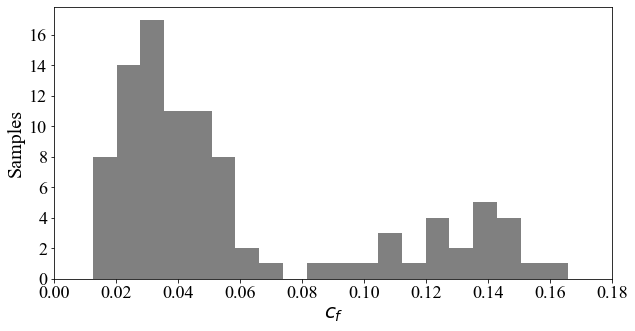

In [17]:
plt.figure(figsize=(10,5))
plt.hist(total_cfs, bins = 20, color = 'gray')
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.xlabel('$c_f$',fontsize = 20)
plt.ylabel('Samples',fontsize = 20)
plt.xlim(0,0.18)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\cf.tif',dpi = 300)
plt.show()

## Create Dataset 

In [ ]:
for i in range(len(aggregated_map)):
    a = np.random.rand()
    if a < 0.3:
        pcd = get_pcd_uncolored(aggregated_map[i])
        op3.io.write_point_cloud(r'D:\LiDAR_Data\MidTown\Stewart\TestSet\Stewart_21\{}'.format(f"{i:06d}.pcd"),pcd)

In [11]:
db = Raster_DBSCAN(window_size=[7,11],eps = 1.5,min_samples = 5,Td_map_szie = [32,1800])

In [5]:
import json

In [2]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\California\2021-12-10-21-0-0.pcap'
end_frame = 18000
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)
Inten_maps = np.array(Inten_maps)

 99%|███████████████████████████████████████████████████████████████████████████▎| 17846/18000 [11:13<00:05, 26.50it/s]


In [6]:

thred_map = gen_bckmap(aggregated_map, N = 10,d_thred = 0.056,bck_n = 3 )

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:12<00:00,  2.28s/it]


In [244]:
%%timeit
thred_map = gen_bckmap(aggregated_map, N = 10,d_thred = 0.056,bck_n = 3 )

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:46<00:00,  1.46s/it]

47.3 s ± 1.36 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
Ind_map = np.arange(57600).reshape((32,1800))
ann_path = r'D:\LiDAR_Data\MidTown\California\TestSet\California_21_ANN\California_21\ann'
ann_list = os.listdir(ann_path)

In [12]:
TP_sum,TN_sum,FP_sum,FN_sum = 0,0,0,0
TP_sum_post,TN_sum_post,FP_sum_post,FN_sum_post = 0,0,0,0
filtering_time = []
Ts_list = []
TPs_list = []
frames = 0
for ind in tqdm(range(len(ann_list))):
    with open(os.path.join(ann_path,ann_list[ind]), 'r') as f:
        frame_ind = int(ann_list[ind][:6])
        ann = json.load(f)
        object_type = [o['classTitle'] for o in ann['objects']]
        pixels = [o['geometry']['indices'] for o in ann['figures']]
        if len(pixels) > 0:
            frames += 1
            Labeling_map = -1*np.ones_like(aggregated_map[frame_ind]).astype('int')
            for i,p in enumerate(pixels):
                for j in p:
                    Labeling_map[Ind_map == j] = i
            Td_map = aggregated_map[frame_ind]
            a = time.time()
            Foreground_map = ~(np.abs(Td_map - thred_map) <= 0.9).any(axis = 0)
            filtering_time.append(1000*(time.time() - a))
            TP = ((Labeling_map != -1)&(Foreground_map == True)).sum()
            TN = ((Labeling_map == -1)&(Foreground_map == False)).sum()
            FP = ((Labeling_map == -1)&(Foreground_map == True)).sum()
            FN = ((Labeling_map != -1)&(Foreground_map == False)).sum()
            TP_sum += TP
            TN_sum += TN
            FP_sum += FP
            FN_sum += FN
            Labeling_map_post = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
            TP = ((Labeling_map != -1)&(Labeling_map_post != -1)).sum()
            TN = ((Labeling_map == -1)&(Labeling_map_post == -1 )).sum()
            FP = ((Labeling_map == -1)&(Labeling_map_post != -1)).sum()
            FN = ((Labeling_map != -1)&(Labeling_map_post == -1)).sum()
            TP_sum_post += TP
            TN_sum_post += TN
            FP_sum_post += FP
            FN_sum_post += FN
            unique_labels = np.unique(Labeling_map)[1:]
            Ts = []
            TPs = []
            for l in unique_labels:
                rows,cols = np.where(Labeling_map == l)
                T = len(rows)
                TP = (Labeling_map_post[rows,cols] != -1).sum()
                Ts.append(T)
                TPs.append(TP)
            Ts_list += Ts
            TPs_list += TPs
TPs_list = np.array(TPs_list)
Ts_list = np.array(Ts_list)
intact = (TPs_list/Ts_list)

100%|█████████████████████████████████████████████████████████████████████████████| 5180/5180 [00:20<00:00, 252.84it/s]


In [13]:
intact.mean()

0.9676350353717987

In [14]:
(intact > 0.5).sum()/len(intact)

0.9875

In [15]:
frames

12

In [16]:
np.mean(filtering_time)

0.9148518244425455

In [17]:
print(TP_sum,FP_sum)

8714 10291


In [18]:
print(TN_sum,FN_sum)

672033 162


In [19]:
print(TP_sum_post,FP_sum_post)

8700 3770


In [20]:
print(TN_sum_post,FN_sum_post)

678554 176


In [21]:
TN_sum/(TN_sum+FN_sum)

0.9997589985048981

In [22]:
precision = TP_sum/(TP_sum+FP_sum)
recall = TP_sum/(TP_sum+FN_sum)

In [23]:
recall

0.9817485353762956

In [24]:
precision

0.45851091817942646

In [25]:
precision = TP_sum_post/(TP_sum_post+FP_sum_post)
recall = TP_sum_post/(TP_sum_post+FN_sum_post)

In [26]:
precision

0.6976744186046512

In [27]:
recall

0.9801712483100495

In [158]:
84.47 - 69.97

14.5

In [7]:
db = Raster_DBSCAN(window_size=[7,11],eps = 1.5,min_samples = 5,Td_map_szie = [32,1800])

In [59]:

pcap_path = r'D:\LiDAR_Data\MidTown\California\2021-12-10-21-0-0.pcap'
end_frame = 18000
num = []
t_db = []
t_bf = []
t_rimg = []
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    a = time.time()
    Frame = next(frame_gen)
    if Frame is None:
        break 
    
    Td_map,Int_map = Frame
    t_rimg.append((time.time() - a)*1000)
    a = time.time()
    Foreground_map = ~(np.abs(Td_map - thred_map) <= 0.9).any(axis = 0)
    t_bf.append((time.time() - a)*1000)
    a = time.time()
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    t_db.append((time.time() - a)*1000)
    num.append(Labeling_map.max() + 1)
    
    

 99%|███████████████████████████████████████████████████████████████████████████▎| 17846/18000 [17:31<00:09, 16.97it/s]


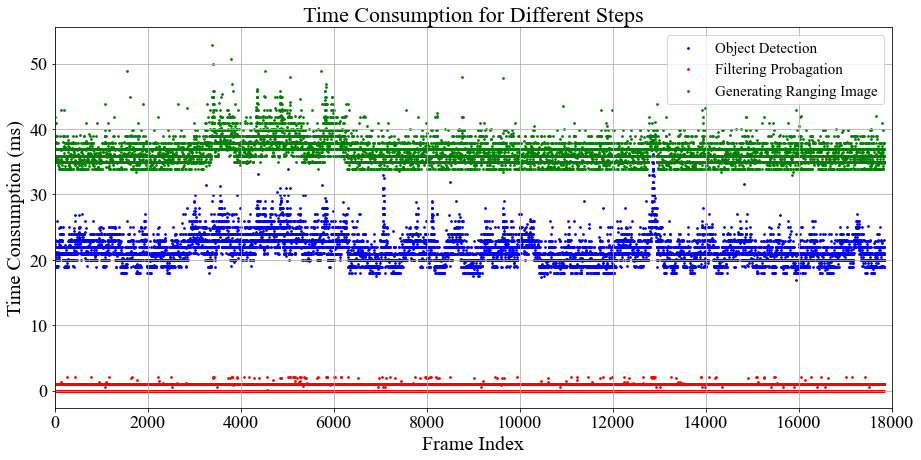

In [66]:
plt.figure(figsize=(15,7))
plt.grid()
plt.scatter(np.arange(len(t_db)),t_db, c = 'b',  label = 'Object Detection', s = 3)
plt.scatter(np.arange(len(t_bf)),t_bf, c = 'r',  label = 'Filtering Probagation', s = 3)
plt.scatter(np.arange(len(t_rimg)),t_rimg, c = 'g',  label = 'Generating Ranging Image', s = 3)
plt.legend(fontsize = 15, loc = 'upper right')
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.xlim(0,18000)
plt.xlabel('Frame Index',fontsize = 20)
plt.ylabel('Time Consumption (ms)',fontsize = 20)
plt.title('Time Consumption for Different Steps', fontsize = 22)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\TimeConsumptionSteps.tif',dpi = 300)
plt.show()

In [65]:
360 * 10 * 32/576000

0.2

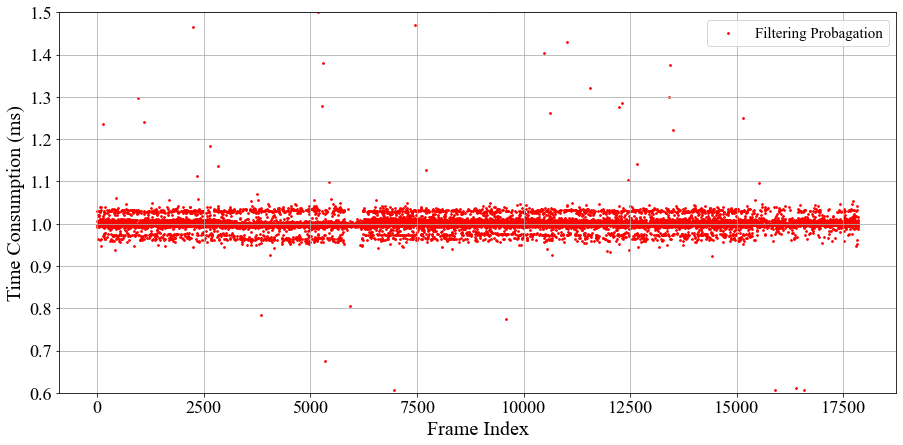

In [71]:
plt.figure(figsize=(15,7))
plt.grid()
# plt.scatter(np.arange(len(t_db)),t_db, c = 'b',  label = 'Object Detection', s = 3)
plt.scatter(np.arange(len(t_bf)),t_bf, c = 'r',  label = 'Filtering Probagation', s = 3)
# plt.scatter(np.arange(len(t_rimg)),t_rimg, c = 'g',  label = 'Generating Ranging Image', s = 3)
plt.legend(fontsize = 15, loc = 'upper right')
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylim(0.6,1.5)
plt.xlabel('Frame Index',fontsize = 20)
plt.ylabel('Time Consumption (ms)',fontsize = 20)
# plt.title('Time Consumption for Different Steps', fontsize = 22)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\TimeConsumptionProb.tif',dpi = 300)
plt.show()

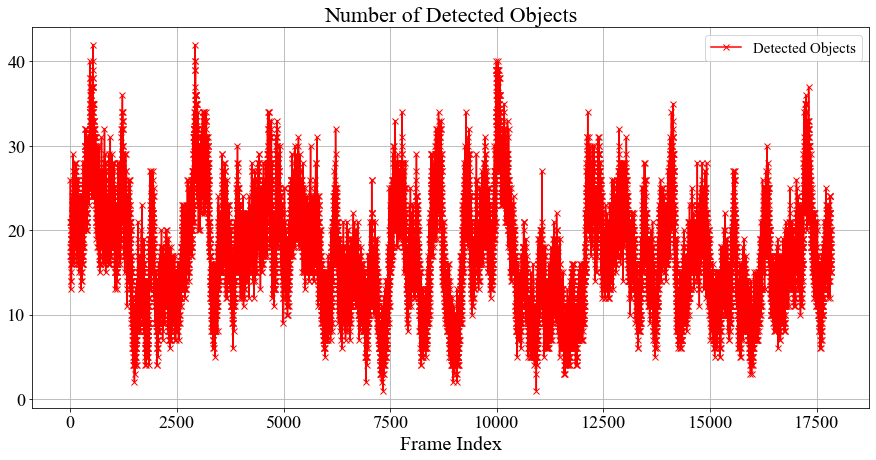

In [18]:
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(num, c = 'r', marker = 'x', label = 'Detected Objects')

plt.legend(fontsize = 15, loc = 'upper right')
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
# plt.ylim(0,0.15)
plt.xlabel('Frame Index',fontsize = 20)
# plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.title('Number of Detected Objects', fontsize = 22)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roNBTU_ts_weekend_zoomin.tif',dpi = 300)
plt.show()

In [23]:
np.argmax(num)

535

In [36]:
db = Raster_DBSCAN(window_size=[9,23],eps = 1.8,min_samples = 5,Td_map_szie = [32,1800])
Td_map = aggregated_map[450]
Foreground_map = ~(np.abs(Td_map - thred_map) <= 0.9).any(axis = 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
pcd = get_pcd_colored(Td_map,Labeling_map)
draw(pcd,height=1000,width=1000)# Labeling_map = self.db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)

WebVisualizer(window_uid='window_18')

In [38]:
42/(15*60)

0.04666666666666667

In [30]:
db = Raster_DBSCAN(window_size=[9,23],eps = 1.8,min_samples = 5,Td_map_szie = [32,1800])
Td_map = aggregated_map[534]
Foreground_map = ~(np.abs(Td_map - thred_map) <= 0.9).any(axis = 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
pcd = get_pcd_colored(Td_map,Labeling_map)
draw(pcd,height=1000,width=1000)# Labeling_map = self.db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)

WebVisualizer(window_uid='window_12')

In [ ]:
pcd = get_pcd_colored(Td_map,Labeling_map)
draw(pcd,height=1000,width=1000)# Labeling_map = self.db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)